In [13]:
import sys

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')
from lift.simulator.simulator import WindowSimulator
from lift.datasets import get_mad_windows
from configs import BaseConfig
config = BaseConfig()

In [3]:
import gymnasium as gym
env = gym.make('FetchReachDense-v2', max_episode_steps=100)

In [10]:
data_path = '../datasets/MyoArmbandDataset/PreTrainingDataset/Female0/training0/'
sim = WindowSimulator(num_actions=5, num_bursts=1, num_channels=8, window_size=200)
sim.fit_params_to_mad_sample(data_path)

In [15]:
window_size = 200
windows, labels = get_mad_windows(data_path, window_size, filter_labels = True)
actions = F.one_hot(labels, num_classes=5).float()

In [17]:
sim_windows = sim(actions)

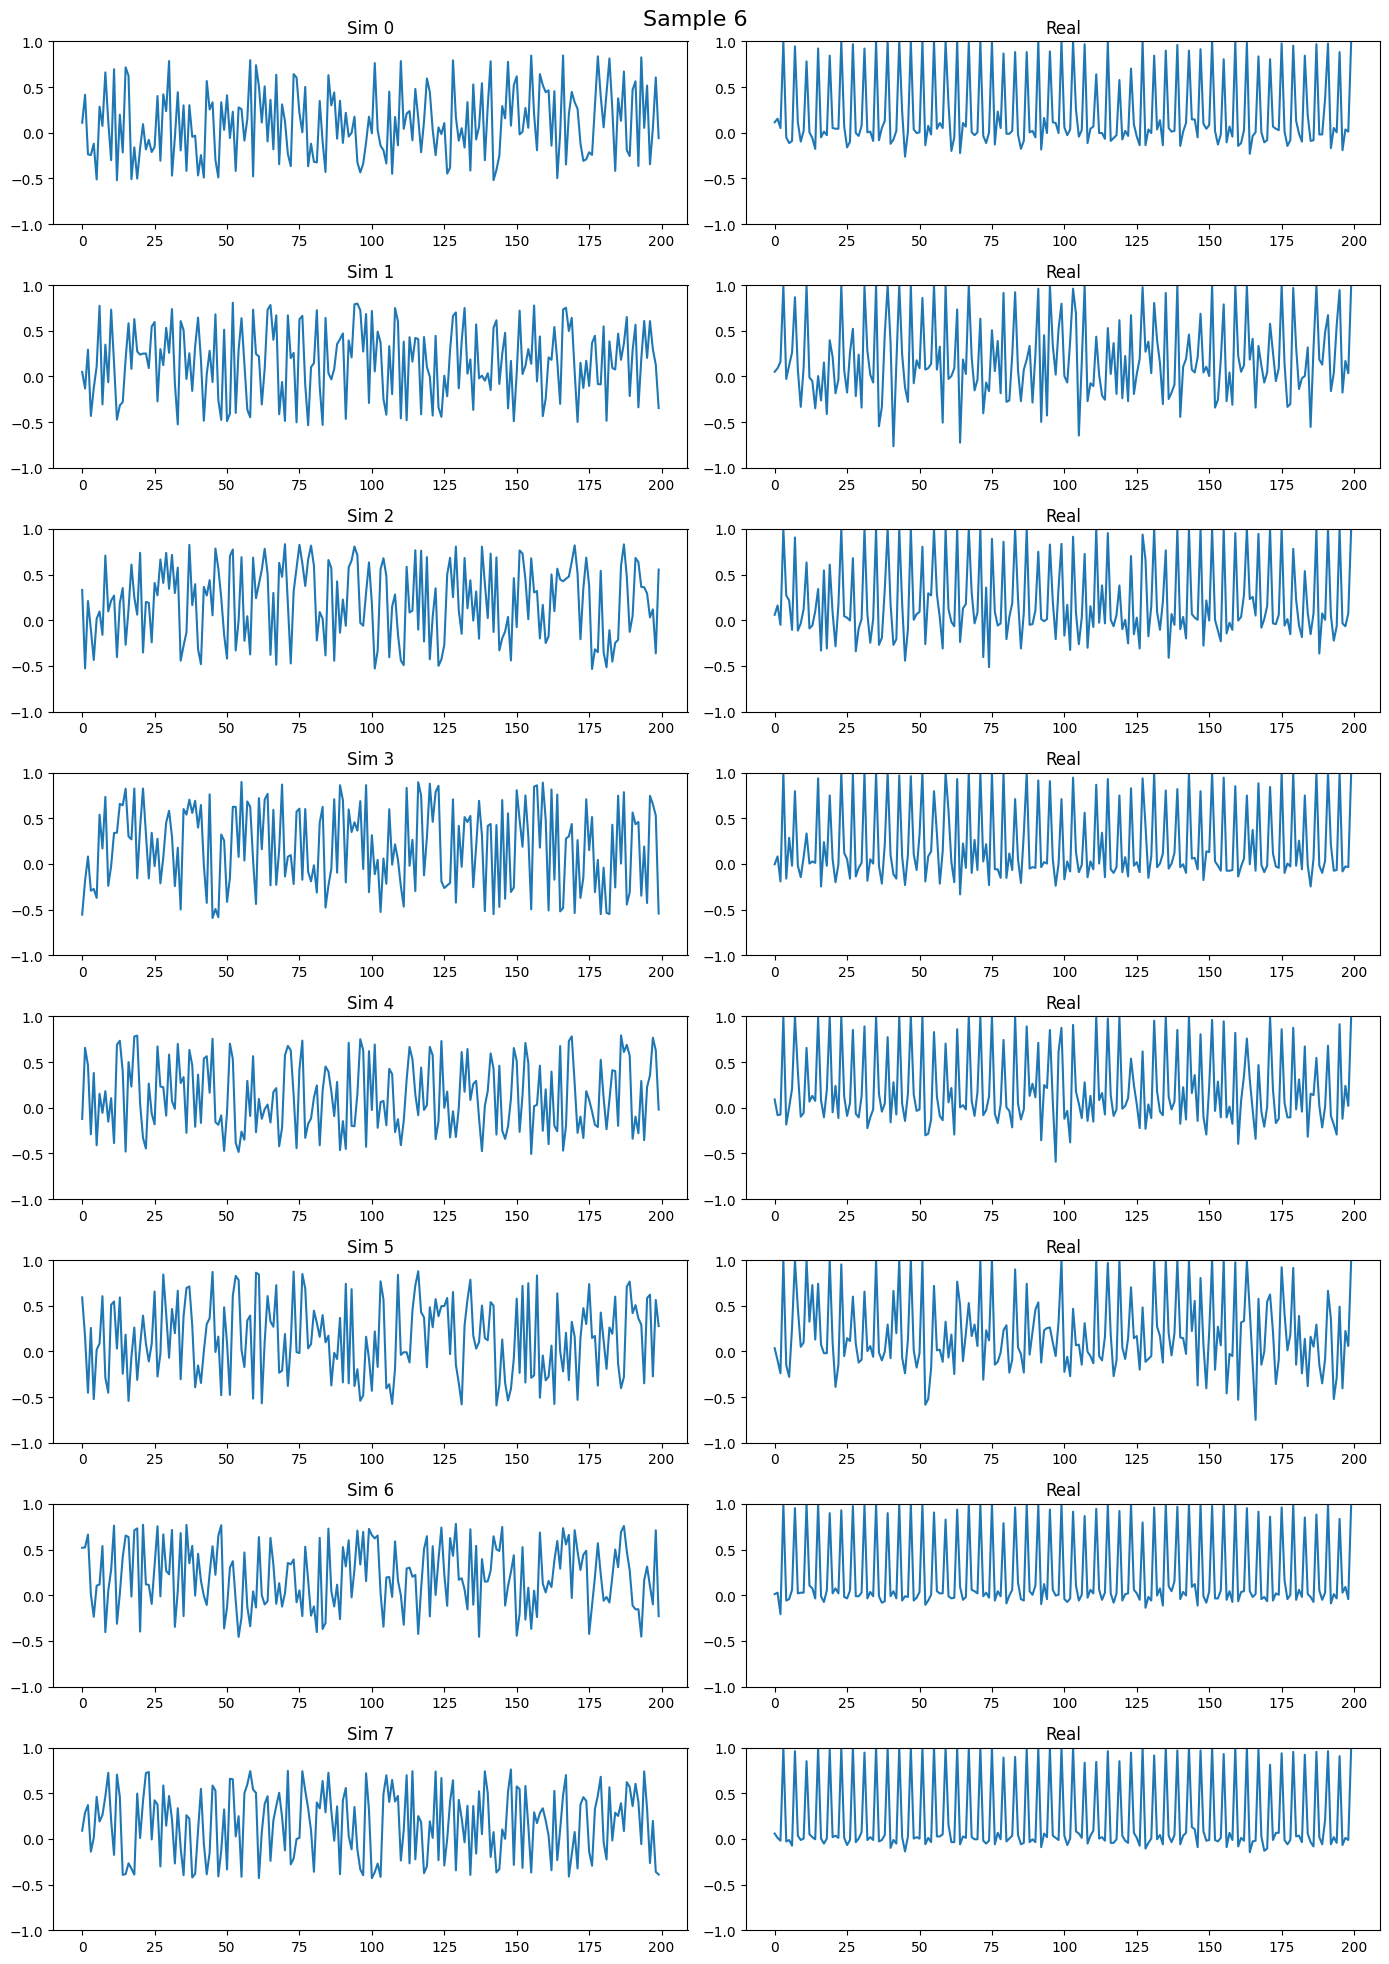

In [18]:
sample_idx = 6
n_channels = 8
fig, axs = plt.subplots(n_channels,2, figsize=(14,20))
for channel_idx in range(n_channels):
    axs[channel_idx,0].plot(sim_windows[sample_idx,channel_idx,:])
    axs[channel_idx,0].set_title(f'Sim {channel_idx}')
    axs[channel_idx,0].set_ylim(-1, 1)
    axs[channel_idx,1].plot(windows[sample_idx,channel_idx,:])
    axs[channel_idx,1].set_title('Real')
    axs[channel_idx,1].set_ylim(-1, 1)
fig.suptitle(f'Sample {sample_idx}', fontsize=16)
plt.tight_layout()
plt.show()

In [21]:
from lift.utils import compute_features

In [23]:
features = compute_features(windows)
sim_features = compute_features(sim_windows)

In [33]:
features_channel = features.view(-1, 8, 4)
sim_features_channel = sim_features.view(-1, 8, 4)

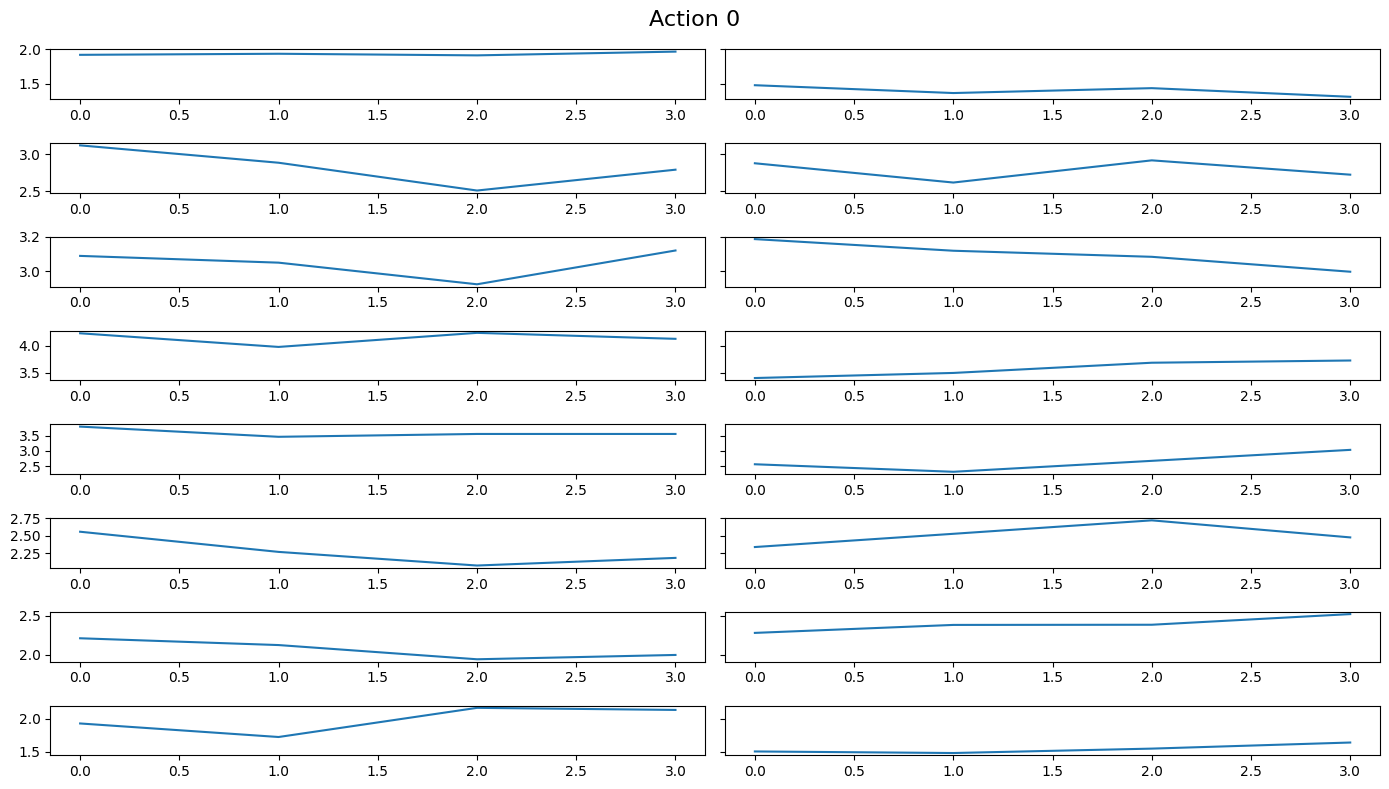

In [34]:
n_consec_samples = 4
n_action = 0
n_channels = 8
feat_idx = 3

s_idx = n_action * n_consec_samples
e_idx = (n_action + 1) * n_consec_samples

action_features = features_channel[s_idx:e_idx]
sim_action_features = sim_features_channel[s_idx:e_idx]

fig, axs = plt.subplots(n_channels, 2, figsize=(14,8), sharey='row')
for channel_idx in range(n_channels):
    axs[channel_idx, 0].plot(action_features[:,channel_idx, feat_idx])
    axs[channel_idx, 1].plot(sim_action_features[:,channel_idx, feat_idx])
fig.suptitle(f'Action {n_action}', fontsize=16)
plt.tight_layout()
plt.show()